## Pop data

In [4]:
## Install required packages in Jupyter Notebook
# %pip install geopandas
# %pip install rasterio
# %pip install --upgrade pandas
# %pip install xlsxwriter


import pandas as pd
import numpy as np
from pathlib import Path

# --- imports ---
from pathlib import Path
import geopandas as gpd
from function_clip_raster_to_aoi import clip_raster_to_aoi


import sys, platform
print("=== Environment Info ===")
print(f"Python version : {sys.version.split()[0]}")
print(f"Python env     : {sys.executable}")
print(f"Platform       : {platform.platform()}")
print(f"geopandas      : {gpd.__version__}")
print(f"numpy          : {np.__version__}")
print(f"pandas         : {pd.__version__}")
print("========================")


=== Environment Info ===
Python version : 3.12.11
Python env     : c:\Users\yingjiel\AppData\Local\miniconda3\envs\py312\python.exe
Platform       : Windows-2019Server-10.0.17763-SP0
geopandas      : 1.1.1
numpy          : 1.26.4
pandas         : 2.3.2


In [39]:


# --- base directory ---
# base_dir = Path(r"G:\Shared drives\Wellcome Trust Project Data")                       # in local PC
base_dir = Path(r"C:\Users\yingjiel\gdrive\Shared drives\Wellcome Trust Project Data") # in SDSS Remote Desktop

# --- AOI path & load ---
aoi_path = base_dir / "1_preprocess" / "UrbanCoolingModel" / "London_Ward_aoi_prj.shp"
aoi = gpd.read_file(aoi_path)

# --- input rasters (folder) & output folder ---
in_dir  = base_dir / "0_source_data" / "population_raster"
out_dir = base_dir / "1_preprocess" / "UrbanCoolingModel" / "OfficialWorkingInputs" / "pop_raster"
out_dir.mkdir(parents=True, exist_ok=True)


In [ ]:

# Optional: if AOI has no CRS, set it (replace EPSG as appropriate)
if aoi.crs is None:
    # Example: set to EPSG:27700 or 3857 or 4326 depending on your data
    # aoi = aoi.set_crs(27700)
    raise ValueError("AOI has no CRS; please set a CRS before clipping.")

# --- loop through all .tif files in the input folder ---
tif_paths = sorted(in_dir.glob("*.tif"))
if not tif_paths:
    raise FileNotFoundError(f"No .tif files found in: {in_dir}")

for tif_in in tif_paths:
    # build output name: <original_stem>_clip2aoi.tif
    tif_out = out_dir / f"{tif_in.stem}_clip2aoi.tif"

    # clip_raster_to_aoi can accept a GeoDataFrame for aoi
    filled_arr, filled_transform, filled_profile = clip_raster_to_aoi(
        raster_path=tif_in,         # Path to input raster
        aoi=aoi,                    # GeoDataFrame (already loaded)
        out_path=tif_out,           # Path to output raster
        replace_nodata_with=0,      # convert NoData to 0
        keep_nodata_tag=False       # ensure 0 is treated as a real class
    )

    print(f"✓ Clipped: {tif_in.name}  →  {tif_out.name}")


## Viz

In [27]:
# --- imports ---
from pathlib import Path
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.enums import Compression
from rasterio.crs import CRS
from typing import Union

def _crs_from_any(x: Union[str, int, CRS]) -> CRS:
    """
    Accept 'EPSG:27700', 27700, proj4 string, or a CRS object.
    Avoids fragile EPSG-only paths.
    """
    if isinstance(x, CRS):
        return x
    try:
        return CRS.from_user_input(x)  # handles EPSG, proj4, WKT, dict
    except Exception as e:
        raise ValueError(f"Could not parse CRS {x!r}: {e}")

def reproject_raster(
    src_path,
    dst_path,
    dst_crs="EPSG:27700",
    dst_res=None,                     # e.g., 100 for 100 m pixels; None = auto
    resampling=Resampling.bilinear,   # bilinear for continuous; nearest for classes
    compress="LZW",                   # GeoTIFF compression
    bigtiff="IF_SAFER",               # allow BigTIFF if needed
):
    src_path = Path(src_path)
    dst_path = Path(dst_path)
    dst_path.parent.mkdir(parents=True, exist_ok=True)

    dst_crs = _crs_from_any(dst_crs)

    with rasterio.open(src_path) as src:
        if src.crs is None:
            raise ValueError(f"Source raster has no CRS: {src_path}")

        src_transform = src.transform
        src_crs = src.crs
        src_dtype = src.dtypes[0]
        nodata = src.nodata

        # Decide resolution / output grid
        if dst_res is not None:
            transform, width, height = calculate_default_transform(
                src_crs, dst_crs, src.width, src.height, *src.bounds, resolution=dst_res
            )
        else:
            transform, width, height = calculate_default_transform(
                src_crs, dst_crs, src.width, src.height, *src.bounds
            )

        # Output dtype: float32 for interpolated data; keep ints for nearest/class data
        out_dtype = src_dtype if resampling == Resampling.nearest else "float32"

        profile = src.profile.copy()
        profile.update(
            driver="GTiff",
            dtype=out_dtype,
            crs=dst_crs,
            transform=transform,
            width=width,
            height=height,
            compress=compress,
            bigtiff=bigtiff,
            nodata=nodata,          # keep same nodata if present
            tiled=False,            # avoids block-size errors; set True with block sizes if desired
            # Example for safe tiling (uncomment to use):
            # tiled=True, blockxsize=256, blockysize=256
        )

        # Reproject band-by-band
        with rasterio.open(dst_path, "w", **profile) as dst:
            for b in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, b),
                    destination=rasterio.band(dst, b),
                    src_transform=src_transform,
                    src_crs=src_crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=resampling,
                    src_nodata=nodata,
                    dst_nodata=nodata,
                )
    return dst_path


In [35]:
from pathlib import Path
import os
import numpy as np
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.crs import CRS

# Proj4 BNG (no EPSG DB required)
BNG_PROJ4 = (
    "+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 "
    "+x_0=400000 +y_0=-100000 +ellps=airy "
    "+towgs84=446.448,-125.157,542.06,0.1502,0.247,0.8421,-20.4894 "
    "+units=m +no_defs"
)
BNG_CRS = CRS.from_string(BNG_PROJ4)

def reproject_raster(
    src_path,
    dst_path,
    dst_crs=BNG_CRS,
    dst_res=None,                         # meters (e.g., 100)
    resampling=Resampling.bilinear,       # nearest for categorical
    compress="LZW",
    bigtiff="IF_SAFER",
):
    src_path = Path(src_path)
    dst_path = Path(dst_path)
    dst_path.parent.mkdir(parents=True, exist_ok=True)

    try:
        with rasterio.open(src_path) as src:
            if src.crs is None:
                raise ValueError(f"Source raster has no CRS: {src_path}")

            # compute target grid
            if dst_res is not None:
                transform, width, height = calculate_default_transform(
                    src.crs, dst_crs, src.width, src.height, *src.bounds, resolution=dst_res
                )
            else:
                transform, width, height = calculate_default_transform(
                    src.crs, dst_crs, src.width, src.height, *src.bounds
                )

            # dtype + nodata
            if resampling == Resampling.nearest:
                out_dtype = src.dtypes[0]
                out_nodata = src.nodata
                if out_nodata is None and "int" in str(out_dtype):
                    # pick a safe sentinel outside common ranges
                    out_nodata = -32768 if out_dtype.startswith("int16") else 0
            else:
                out_dtype = "float32"
                out_nodata = -9999.0  # concrete float nodata (avoid NaN for GeoTIFF tags)

            # profile
            profile = src.profile.copy()
            profile.update(
                driver="GTiff",
                dtype=out_dtype,
                count=src.count,
                crs=dst_crs,
                transform=transform,
                width=width,
                height=height,
                compress=compress,
                bigtiff=bigtiff,
                nodata=out_nodata,
                tiled=True,            # tiles instead of strips → no StripOffsets issues
                blockxsize=256,
                blockysize=256,
            )

            with rasterio.open(dst_path, "w", **profile) as dst:
                # reproject per band via arrays (safer than band-to-band handles)
                for b in range(1, src.count + 1):
                    dest = np.full((height, width), out_nodata, dtype=profile["dtype"])
                    reproject(
                        source=rasterio.band(src, b),
                        destination=dest,
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=transform,
                        dst_crs=dst_crs,
                        resampling=resampling,
                        src_nodata=src.nodata,
                        dst_nodata=out_nodata,
                    )
                    dst.write(dest, b)
        return dst_path

    except Exception as e:
        # clean up half-written file so GDAL won't later complain about StripOffsets
        if dst_path.exists():
            try: dst_path.unlink()
            except Exception: pass
        raise


In [36]:
in_dir = Path(out_dir)  # your clipped rasters folder
out_dir_proj = in_dir / "epsg27700"
out_dir_proj.mkdir(parents=True, exist_ok=True)

for p in sorted(in_dir.glob("*.tif")):
    out_p = out_dir_proj / f"{p.stem}_EPSG27700_100m.tif"
    reproject_raster(
        p, out_p,
        dst_crs=BNG_CRS,          # avoids broken EPSG DB
        dst_res=100,
        resampling=Resampling.bilinear,  # nearest for categorical
    )
    print(f"✓ {p.name} → {out_p.name}")


INFO:rasterio._err:GDAL signalled an error: err_no=1, msg='PROJ: proj_create_from_name: C:\\Users\\yingjiel\\AppData\\Local\\miniconda3\\envs\\py312\\Library\\share\\proj\\proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 4 is expected. It comes from another PROJ installation.'


✓ gbr_pop_2021_CN_100m_R2025A_v1_clip2aoi.tif → gbr_pop_2021_CN_100m_R2025A_v1_clip2aoi_EPSG27700_100m.tif


INFO:rasterio._err:GDAL signalled an error: err_no=1, msg='PROJ: proj_create_from_name: C:\\Users\\yingjiel\\AppData\\Local\\miniconda3\\envs\\py312\\Library\\share\\proj\\proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 4 is expected. It comes from another PROJ installation.'


✓ gbr_pop_2030_CN_100m_R2025A_v1_clip2aoi.tif → gbr_pop_2030_CN_100m_R2025A_v1_clip2aoi_EPSG27700_100m.tif


INFO:rasterio._err:GDAL signalled an error: err_no=1, msg='PROJ: proj_create_from_name: C:\\Users\\yingjiel\\AppData\\Local\\miniconda3\\envs\\py312\\Library\\share\\proj\\proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 4 is expected. It comes from another PROJ installation.'


✓ gbr_ppp_2020_UNadj_constrained_clip2aoi.tif → gbr_ppp_2020_UNadj_constrained_clip2aoi_EPSG27700_100m.tif


Shared color scale -> vmin: 0.000, vmax: 129.050


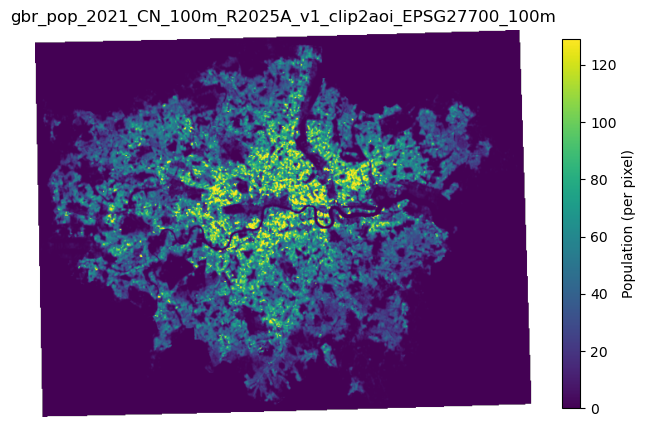

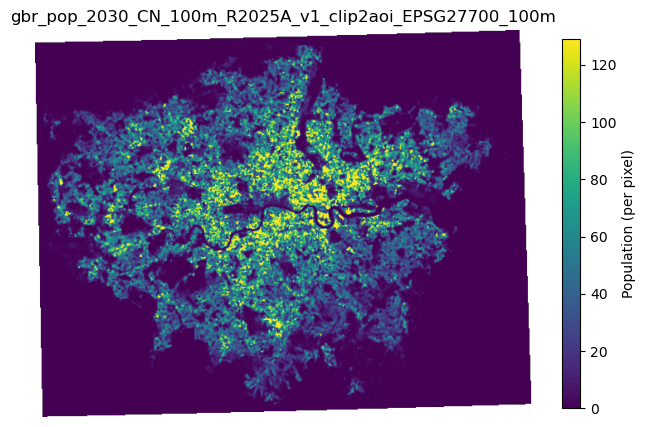

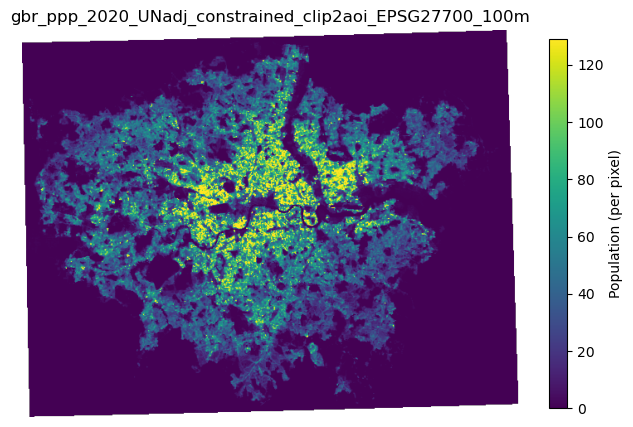

In [37]:
from pathlib import Path
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from zipfile import ZipFile

# --- Set your folder with clipped rasters here ---
base_dir = Path(r"G:\Shared drives\Wellcome Trust Project Data")
in_dir   = out_dir_proj  # using the output folder from previous step

tifs = sorted(in_dir.glob("*.tif"))
if not tifs:
    raise FileNotFoundError(f"No .tif files found in: {in_dir}")

# --- Compute shared color scale (robust) ---
samples = []
max_samples_per_file = 500_000  # reduce if memory is tight

for path in tifs:
    with rasterio.open(path) as src:
        arr = src.read(1, masked=True)           # drop nodata via mask
        data = arr.compressed()
        if data.size == 0:
            continue
        if data.size > max_samples_per_file:
            idx = np.random.choice(data.size, size=max_samples_per_file, replace=False)
            data = data[idx]
        samples.append(data)

if not samples:
    raise RuntimeError("All rasters were empty after masking; cannot set color scale.")

all_samples = np.concatenate(samples)
vmin = float(np.percentile(all_samples, 1))
vmax = float(np.percentile(all_samples, 99))
if vmin >= vmax:  # degenerate case fallback
    vmin, vmax = float(np.min(all_samples)), float(np.max(all_samples))

print(f"Shared color scale -> vmin: {vmin:.3f}, vmax: {vmax:.3f}")

# --- Plot each raster with the same scale and save PNGs ---
out_img_dir = in_dir / "png_previews"
out_img_dir.mkdir(parents=True, exist_ok=True)

saved_pngs = []
for path in tifs:
    with rasterio.open(path) as src:
        arr = src.read(1, masked=True)
        fig = plt.figure(figsize=(8, 6))                # one figure per raster (no subplots)
        im = plt.imshow(arr, vmin=vmin, vmax=vmax)      # default colormap; uniform scale
        plt.title(path.stem, fontsize=12)
        plt.axis("off")
        cbar = plt.colorbar(im, shrink=0.8)
        cbar.set_label("Population (per pixel)")
        png_path = out_img_dir / f"{path.stem}.png"
        plt.savefig(png_path, dpi=200, bbox_inches="tight")
        plt.show()
        saved_pngs.append(png_path)

# # --- Zip them for quick sharing ---
# zip_path = in_dir / "worldpop_clipped_maps.zip"
# with ZipFile(zip_path, "w") as zf:
#     for p in saved_pngs:
#         zf.write(p, arcname=p.name)

# print(f"Saved {len(saved_pngs)} PNGs to: {out_img_dir}")
# print(f"ZIP: {zip_path}")


### zoom in plot

INFO:rasterio._err:GDAL signalled an error: err_no=1, msg='PROJ: proj_create_from_name: C:\\Users\\yingjiel\\AppData\\Local\\miniconda3\\envs\\py312\\Library\\share\\proj\\proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 4 is expected. It comes from another PROJ installation.'
INFO:rasterio._env:GDAL signalled an error: err_no=1, msg='PROJ: proj_create_from_database: C:\\Users\\yingjiel\\AppData\\Local\\miniconda3\\envs\\py312\\Library\\share\\proj\\proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 4 is expected. It comes from another PROJ installation.'
INFO:rasterio._env:GDAL signalled an error: err_no=1, msg='PROJ: proj_create_from_database: C:\\Users\\yingjiel\\AppData\\Local\\miniconda3\\envs\\py312\\Library\\share\\proj\\proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 4 is expected. It comes from another PROJ installation.'
INFO:rasterio._err:GDAL signalled an error: err_no=1, msg='PROJ: proj_create_from_name: C:\\

Shared color scale: vmin=0.000, vmax=171.913


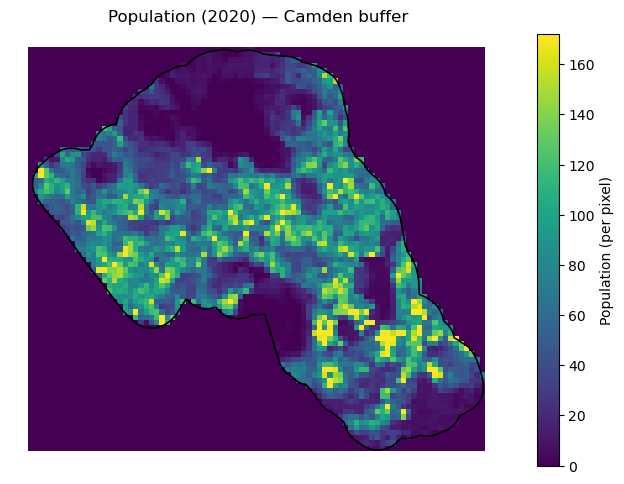

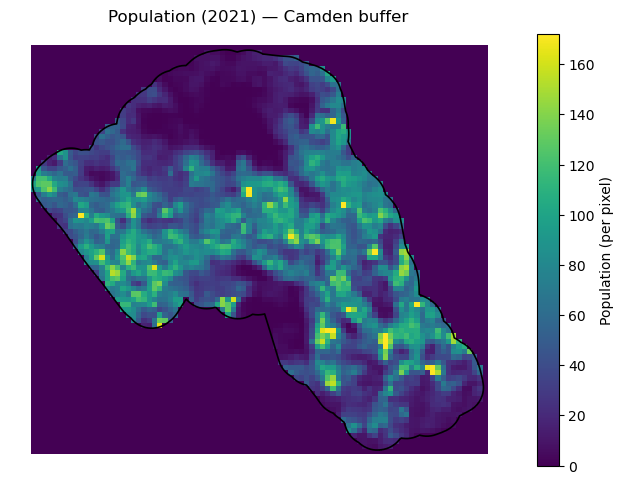

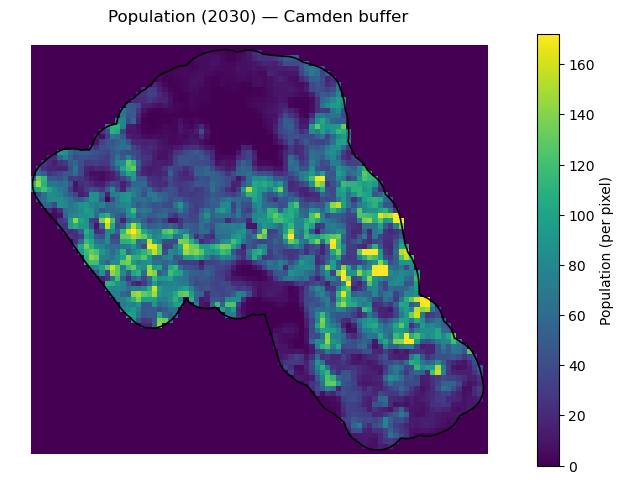

In [41]:
# --- imports ---
from pathlib import Path
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.warp import Resampling, calculate_default_transform, reproject
import matplotlib.pyplot as plt

# ========= USER SETTINGS =========
# Base folders (adjust as needed)
model_dir   = base_dir / "1_preprocess" / "UrbanCoolingModel" / "OfficialWorkingInputs" / "AOIs"
aoi_path   = model_dir / "camden_borough_500m_buffer.shp"

# Folder containing your population rasters (e.g., the *_EPSG27700_100m.tif you just created)
pop_dir    = out_dir_proj

# Years to plot (edit if different). The code will try to match filenames containing these.
years = [2020, 2021, 2030]

# Optional: if your rasters are not in EPSG:27700, set this to AOI CRS; we'll reproject on the fly if needed
TARGET_CRS = None  # None → use AOI's CRS
# =================================

# --- load AOI ---
aoi = gpd.read_file(aoi_path)
if aoi.empty:
    raise RuntimeError(f"AOI is empty: {aoi_path}")

if aoi.crs is None:
    raise ValueError("AOI has no CRS. Please set a CRS on the shapefile first.")
if TARGET_CRS is None:
    TARGET_CRS = aoi.crs  # use AOI CRS as target

# --- find rasters per year ---
def find_raster_for_year(folder: Path, year: int):
    # Try a few common substrings: '2020', '_2020_', etc.
    # Adjust if your naming scheme is different.
    candidates = sorted(
        [p for p in folder.glob("*.tif") if str(year) in p.name]
    )
    if not candidates:
        raise FileNotFoundError(f"No GeoTIFF found in {folder} containing '{year}'.")
    # If multiple matches, pick the last one (often the newest) — or customize here
    return candidates[-1]

rasters = {yr: find_raster_for_year(pop_dir, yr) for yr in years}

# --- helper: read + (optional) reproject + mask to AOI ---
def read_masked(path: Path, aoi_gdf: gpd.GeoDataFrame, target_crs):
    with rasterio.open(path) as src:
        src_crs = src.crs
        if src_crs is None:
            raise ValueError(f"Raster has no CRS: {path}")

        # Reproject AOI to raster CRS for masking, if needed
        if aoi_gdf.crs != src_crs:
            aoi_in_src = aoi_gdf.to_crs(src_crs)
        else:
            aoi_in_src = aoi_gdf

        # Mask to AOI
        geoms = [geom for geom in aoi_in_src.geometry if geom is not None]
        if not geoms:
            raise RuntimeError("AOI has no valid geometries.")
        data, transform = mask(src, geoms, crop=True, filled=True, nodata=src.nodata)
        profile = src.profile.copy()
        profile.update({
            "height": data.shape[1],
            "width": data.shape[2],
            "transform": transform
        })

        # If target CRS differs from raster CRS, reproject the masked array
        if target_crs is not None and target_crs != src_crs:
            # Build a virtual in-memory dataset for the masked window
            # Then calculate new grid in target CRS and reproject
            from rasterio.io import MemoryFile
            with MemoryFile() as memfile:
                with memfile.open(**profile) as mem:
                    mem.write(data)
                    transform2, w2, h2 = calculate_default_transform(
                        mem.crs, target_crs, mem.width, mem.height, *mem.bounds
                    )
                    out = np.zeros((mem.count, h2, w2), dtype=data.dtype)
                    for b in range(1, mem.count + 1):
                        reproject(
                            source=rasterio.band(mem, b),
                            destination=out[b-1],
                            src_transform=mem.transform,
                            src_crs=mem.crs,
                            dst_transform=transform2,
                            dst_crs=target_crs,
                            resampling=Resampling.bilinear,
                            src_nodata=profile.get("nodata"),
                            dst_nodata=profile.get("nodata"),
                        )
            data = out
            transform = transform2
            profile.update({"crs": target_crs, "transform": transform, "height": h2, "width": w2})
        return data[0], transform, profile  # assume single-band population rasters

# --- read & mask all three, compute shared color scale ---
arrays = {}
transforms = {}
profiles = {}
samples = []
for yr, tif in rasters.items():
    arr, tfm, prof = read_masked(tif, aoi, TARGET_CRS)
    arrays[yr] = arr
    transforms[yr] = tfm
    profiles[yr] = prof

    # collect robust samples for shared color scale
    m = np.ma.masked_equal(arr, prof.get("nodata")) if prof.get("nodata") is not None else np.ma.masked_invalid(arr)
    if m.mask is np.bool_ or not hasattr(m.mask, "sum"):
        data_flat = m.compressed()
    else:
        data_flat = m.compressed()
    if data_flat.size:
        # random subsample if huge
        if data_flat.size > 500_000:
            idx = np.random.choice(data_flat.size, 500_000, replace=False)
            data_flat = data_flat[idx]
        samples.append(data_flat)

if not samples:
    raise RuntimeError("All masked rasters are empty over the AOI.")

all_s = np.concatenate(samples)
vmin = float(np.percentile(all_s, 1))
vmax = float(np.percentile(all_s, 99))
if vmin >= vmax:
    vmin, vmax = float(np.min(all_s)), float(np.max(all_s))

print(f"Shared color scale: vmin={vmin:.3f}, vmax={vmax:.3f}")

# --- plotting (one figure per year), zoom to AOI bounds ---
# Compute AOI bounds in TARGET_CRS for consistent xlim/ylim
aoi_plot = aoi if aoi.crs == TARGET_CRS else aoi.to_crs(TARGET_CRS)
minx, miny, maxx, maxy = aoi_plot.total_bounds
padx = (maxx - minx) * 0.05
pady = (maxy - miny) * 0.05

for yr in years:
    arr = arrays[yr]
    tfm = transforms[yr]

    fig = plt.figure(figsize=(8, 7))  # one plot per year
    ax = plt.gca()

    # extent from transform for correct georeferenced placement
    height, width = arr.shape
    xmin, ymax = tfm * (0, 0)
    xmax, ymin = tfm * (width, height)
    extent = (xmin, xmax, ymin, ymax)

    im = ax.imshow(arr, extent=extent, vmin=vmin, vmax=vmax, origin="upper")
    # AOI outline
    aoi_plot.boundary.plot(ax=ax, linewidth=1.2, edgecolor="black")

    ax.set_xlim(minx - padx, maxx + padx)
    ax.set_ylim(miny - pady, maxy + pady)
    ax.set_title(f"Population ({yr}) — Camden buffer", fontsize=12)

    # remove axes (ticks + labels + spines)
    ax.set_axis_off()
    # ax.set_xlabel("Easting"); ax.set_ylabel("Northing")
    
    ax.set_aspect("equal", adjustable="box")
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label("Population (per pixel)")
    plt.show()
